# Analysis Tutorial

This tutorial demonstrates how to analyze and interpret the outputs from Connectomemapper 3. In particular it will tell you how to:

- Get the list of connectome files with [Pybids](https://pypi.org/project/pybids/)
- Read the .tsv connectome files with [Networkx](https://pypi.org/project/networkx/) and [Pandas](https://pandas.pydata.org/)
- Read the .gpickle files with Networkx
- Read the .mat files with [Scipy](https://scipy.org/)
- Compute the connectome harmonics with [PyGSP](https://pygsp.readthedocs.io/en/stable/index.html)
- Visualize the harmonics with the plot functions of [Nilearn](https://nilearn.github.io/stable/index.html)

## Setup instructions

If you want to reproduce all the results of this notebook on your side, a conda ``environment.yml`` file can be downloaded at the following link: [tutorial_environment.yml](tutorial_environment.yml). The original ``.ipynb`` notebook file can be downloaded at the following link: [analysis_tutorial.ipynb](https://github.com/connectomicslab/connectomemapper3/raw/master/docs/notebooks/analysis_tutorial.ipynb).

Once you have downloaded the conda environment file, install the environment as follows:
```bash
$ conda env create -f /path/to/downloaded/analysis_tutorial.yml
```
This will install all the packages needed to run this notebook including jupyter lab.

You can then activate it, go to the directory where you downloaded the ``analysis_tutorial.ipynb``, and launch jupyter lab as follows:

```bash
$ cd /directory/of/downloaded/analysis_tutorial.ipynb/
$ conda activate cmp3-tutorial
$ jupyter lab
```

You are ready to open and interact with the notebook!

## Loading the external python packages

In [1]:
# General
import os
import sys
import subprocess
import copy

# Dataset management
import datalad.api as dl

# Data handling
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# BIDS dataset handling
from bids import BIDSLayout

# Network / Graph
import pygsp
import networkx as nx

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import nilearn
from nilearn import plotting, image, datasets

/Applications/miniconda3/envs/cmp3-tutorial/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


## Loading the connectome files

For demonstration, we are going to use the latest version of VEPCON dataset, available on [Open Neuro](https://openneuro.org/datasets/ds003505/versions/1.1.1) that already contains output from Connectome Mapper v3.0.3. A full description of the dataset can be found in [Pascucci, Tourbier, et al. 2022].

In case you want to rerun the notebook, make sure to remove any `ds003505_demo` folder in the directory of the notebook. Otherwise, datalad install will complain.

[Pascucci, Tourbier, et al. 2022]: https://doi.org/10.1038/s41597-021-01116-1

In [2]:
%%time
# Download example dataset with datalad
dataset_dir = os.path.join(".", "ds003505_demo")
vepcon_data = dl.install(
    path=dataset_dir,
    source="https://github.com/OpenNeuroDatasets/ds003505.git"
)


[INFO] Cloning dataset to Dataset(/Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo) 
[INFO] Attempting to clone from https://github.com/OpenNeuroDatasets/ds003505.git to /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo 
[INFO] Start enumerating objects 
[INFO] Start receiving objects 
[INFO] Start resolving deltas 
[INFO] Completed clone attempts for Dataset(/Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo) 
[INFO] scanning for annexed files (this may take some time) 
[INFO] Remote origin not usable by git-annex; setting annex-ignore 
[INFO] https://github.com/OpenNeuroDatasets/ds003505.git/config download failed: Not Found 
[INFO] access to 1 dataset sibling s3-PRIVATE not auto-enabled, enable with:
| 		datalad siblings -d "/Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo" enable -s s3-PRIVATE 


CPU times: user 97 ms, sys: 74.8 ms, total: 172 ms
Wall time: 9.41 s


As the dataset is in [BIDS](https://bids.neuroimaging.io/), we can use [Pybids](https://bids-standard.github.io/pybids/) to help us with the task of interacting with the files of the dataset.

In [3]:
# Represent the BIDS dataset as a PyBIDS BIDSLayout
layout = BIDSLayout(vepcon_data.path)
# Add derivative folder containing the connectivity matrices
layout.add_derivatives(os.path.join(vepcon_data.path, "derivatives", "cmp-v3.0.3"))

Now we can easily query for the filenames of the files we are interested in using `layout.get`. We will ask for the connectivity matrix of subject 01, scale 3, in tsv format.

It will be returned as a list of file paths (in this case containing just one element). Note that at this stage the Datalad dataset contains mostly file annexes.

As the connectome in TSV format, are just text files, they are directly managed by Git, such that we do have to retrieve its actual content before querying them.

In [4]:
# Query the connectome file path
conn_tsv_scale3 = layout.get(
    subject='01',
    datatype='dwi',
    atlas='L2018',
    res='scale3',
    suffix='connectivity',
    extension='tsv',
    return_type='filename'
)
conn_tsv_scale3

['/Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/cmp-v3.0.3/sub-01/dwi/sub-01_atlas-L2018_res-scale3_conndata-network_connectivity.tsv']

We can then use [Pandas](https://pandas.pydata.org/) to read the file and display it as a table.

In [5]:
edges = pd.read_csv(conn_tsv_scale3[0], delimiter="\t")
edges.head()

,source,target,number_of_fibers,fiber_length_mean,fiber_length_median,fiber_length_std,fiber_proportion,fiber_density,normalized_fiber_density,FA_mean,FA_std,FA_median,ADC_mean,ADC_std,ADC_median
0,1,1,193,6.800518,6.000000,2.242513,0.118146,0.007391,0.052092,0.196300,0.084466,0.177124,0.000785,0.000082,0.000777
1,1,8,23,16.173914,17.000004,5.212046,0.014080,0.000411,0.002896,0.227573,0.094389,0.218950,0.000815,0.000067,0.000813
2,1,3,98,9.382652,8.000008,3.732647,0.059991,0.002899,0.020433,0.195890,0.081233,0.185918,0.000786,0.000069,0.000790
3,1,4,5,23.299999,23.000008,0.678231,0.003061,0.000070,0.000490,0.229370,0.093624,0.229142,0.000787,0.000086,0.000782
4,1,111,63,9.484127,8.499999,3.311797,0.038566,0.001030,0.007262,0.242134,0.064675,0.254462,0.000816,0.000096,0.000803


Using [Networkx](https://networkx.org/documentation/stable/index.html), we can convert this table to a network graph. From that, we can convert individual measures to a [Numpy](https://numpy.org/) array. The array format is especially useful, as it allows us to plot the edge weights easily.

In [6]:
G = nx.from_pandas_edgelist(edges, edge_attr=True)
A_fiber_density = nx.to_numpy_array(G, weight="fiber_density")
A_fiber_density

array([[0.00739067, 0.00041088, 0.00289892, ..., 0.        , 0.        ,
        0.        ],
       [0.00041088, 0.00541092, 0.00340868, ..., 0.        , 0.        ,
        0.        ],
       [0.00289892, 0.00340868, 0.0055656 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00909844, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00863366,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00504128]])

Alternatively, we can also load the matrices in network format, by reading the gpickle files using Networkx:

In [7]:
# Retrieve content of the connectome file with datalad
vepcon_data.get('derivatives/cmp-v3.0.3/sub-01/dwi/sub-01_atlas-L2018_res-scale3_conndata-network_connectivity.gpickle')
# Query the connectome file path
conn_gpickle_scale3 = layout.get(
    subject='01',
    datatype='dwi',
    atlas='L2018',
    res='scale3',
    suffix='connectivity',
    extension='gpickle',
    return_type='filename'
)
G = nx.read_gpickle(conn_gpickle_scale3[0])  # same format as with tsv
A_fiber_density = nx.to_numpy_array(G, weight="fiber_density")
A_fiber_density

array([[7.39067471e-03, 4.01920257e-04, 2.89891974e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.01920257e-04, 7.98799252e-03, 6.66710786e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.89891974e-03, 6.66710786e-03, 5.56559629e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.84868693e-03, 6.47767105e-04, 1.57817881e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.47767105e-04, 1.18190323e-03, 1.05523480e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.57817881e-04, 1.05523480e-05, 8.37270426e-05]])

...or load the .mat files with [Scipy](https://scipy.org/):

In [8]:
# Retrieve content of the connectome file with datalad
vepcon_data.get('derivatives/cmp-v3.0.3/sub-01/dwi/sub-01_atlas-L2018_res-scale3_conndata-network_connectivity.mat')
# Query the connectome file path
conn_mat_scale3 = layout.get(
    subject='01',
    datatype='dwi',
    atlas='L2018',
    res='scale3',
    suffix='connectivity',
    extension='mat',
    return_type='filename'
)
A_mat = sio.loadmat(conn_mat_scale3[0])

The adjacency matrices here can be accessed as followss:

In [9]:
A_mat["sc"]["fiber_density"][0][0]

array([[7.39067471e-03, 4.01920257e-04, 2.89891974e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.01920257e-04, 7.98799252e-03, 6.66710786e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.89891974e-03, 6.66710786e-03, 5.56559629e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.84868693e-03, 6.47767105e-04, 1.57817881e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.47767105e-04, 1.18190323e-03, 1.05523480e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.57817881e-04, 1.05523480e-05, 8.37270426e-05]])

 Note that in these two situations, the connectome files are not directly managed by Git and their actual content need to be first retrieved with the datalad get command.

## Plotting the adjacency matrices

Let's plot some of those adjacency matrices using [Matplotlib](https://matplotlib.org/) and [Seaborn](http://seaborn.pydata.org/index.html):

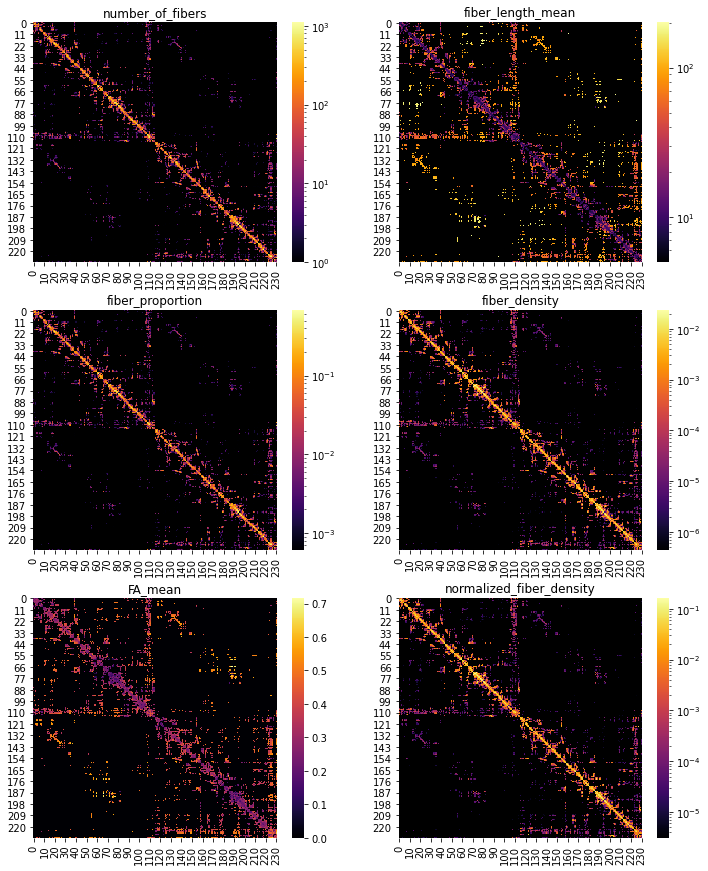

In [10]:
# Create color map to handle zeros with log visualization
custom_cmap = copy.copy(plt.cm.get_cmap("inferno"))
# Copy the default cmap (0,0,0.5156)
custom_cmap.set_bad((0, 0, 0))

# Define the metrics to plot
cols_to_plot = ["number_of_fibers", "fiber_length_mean",
                "fiber_proportion", "fiber_density",
                "FA_mean", "normalized_fiber_density"]

# Plot with log-scale for all metrics except FA_mean
fig, axs = plt.subplots(3,2, figsize=(12,15))
axs = axs.flatten()
for c, ax in zip(cols_to_plot, axs):
    A = nx.to_numpy_array(G, weight=c)
    sns.heatmap(A, ax=ax, cmap=custom_cmap, norm=(LogNorm()
                                                  if c != "FA_mean"
                                                  else None))
    ax.set_title(c)

## Graph signal processing with structural connectivity and visualization

The package [PyGSP](https://pygsp.readthedocs.io/en/stable/index.html) offers a range of graph signal processing tools we can use on our structural connectivity data. In particular, we can do an eigendecomposition of the [graph Laplacian](https://en.wikipedia.org/wiki/Laplacian_matrix) to get the Fourier basis - the connectome harmonics.

Even though it is possible to also do this for subcortical regions, for the sake of plotting it is easier just to work with the cortical regions. To identify those, we need the parcellation labels.

In [11]:
# Query the BIDS index/label mapping TSV file for the corresponding scale
label_path = layout.get(subject='01',
                    datatype='anat',
                    atlas='L2018',
                    res='scale3',
                    suffix='dseg',
                    extension='tsv',
                    return_type='filename')
print(f' BIDS index/label mapping TSV filepath: {label_path[0]}')

 BIDS index/label mapping TSV filepath: /Users/sebastientourbier/Documents/GitHub/connectomemapper3/docs/notebooks/ds003505_demo/derivatives/cmp-v3.0.3/sub-01/anat/sub-01_atlas-L2018_res-scale3_dseg.tsv


In [12]:
# Load the TSV content
labels = pd.read_csv(label_path[0], sep="\t", index_col=0)
# Reset index to start at 0
labels.reset_index(inplace=True)
# Select cortex labels
labels_ctx = labels["name"][[n.startswith("ctx") for n in labels["name"]]].copy()
idx = list(labels_ctx.index)
# Select rows with cortical areas
# A_fd_ctx = A_fiber_density[idx]
A = nx.to_numpy_array(G, weight="FA_mean")
A_fd_ctx = A[idx]
# Select columns with cortical areas
A_fd_ctx = A_fd_ctx[:,idx]

In [13]:
# Display the shape of the matrix
A_fd_ctx.shape

(216, 216)

Now we can compute the harmonics:

In [14]:
np.fill_diagonal(A_fd_ctx, 0)  # PyGSP does not support self-loops
G_fd = pygsp.graphs.Graph(A_fd_ctx)  # PyGSP graph
G_fd.compute_laplacian(lap_type="normalized")
G_fd.compute_fourier_basis()  # compute connectome harmonics

The harmonics have the same dimensions as our original adjacency matrix.

In [15]:
# Display the shape of the matrix
G_fd.U.shape

(216, 216)

Each column contains one basis vector.

### Basic visualization with ``Nilearn``

[Nilearn](https://nilearn.github.io/stable/index.html) offers a quick and easy way to plot them using `plot_markers`. For this, we need the center coordinates of each region in the parcellation in MNI space. For your convenience, they have been already computed and can be easily retrieved with the `get_lausanne2018_parcellation_mni_coords(scale)` utility function of CMP3.

In [16]:
# Import the util function
from cmtklib.data.parcellation.util import get_lausanne2018_parcellation_mni_coords

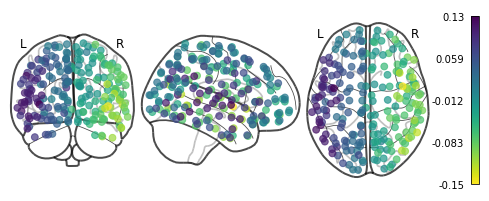

In [17]:
# Load coordinates with the utility function provided by CMP3
coords_ctx = get_lausanne2018_parcellation_mni_coords('scale3')
# Plot
plotting.plot_markers(G_fd.U[:,1], coords_ctx)

### Advanced visualization with ``Nilearn``

A prettier version is to plot the connectome harmonics on a brain surface using Nilearn `plot_surf_roi()`. For your convenience, a multiple view plot can be easily generated and saved with the `plot_lausanne2018_surface_ctx()` of the `cmtklib.data.parcellation.viz` module of CMP3, by specifying the scale to use.

These figures take a few minutes to generate, so you might need to be a bit patient.

In [18]:
# Import the viz function
from cmtklib.data.parcellation.viz import plot_lausanne2018_surface_ctx

CPU times: user 1min 37s, sys: 5.73 s, total: 1min 43s
Wall time: 1min 23s


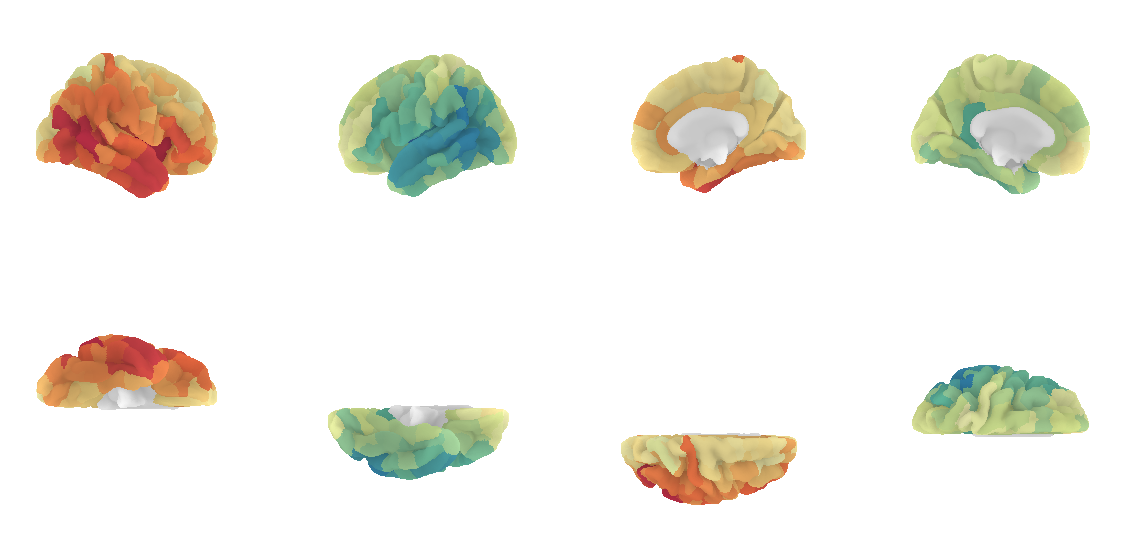

In [19]:
%%time
# Plot
plot_lausanne2018_surface_ctx(G_fd.U[:,1], scale='scale3', save_fig=True)

Pretty, right? This concludes the tutorial. We hope you enjoy it and any feedback or suggestions to improve it are very welcome! Just please open a [new issue](https://github.com/connectomicslab/connectomemapper3/issues/new) on GitHub and share your thoughts with us.

## Want to learn more about connectome harmonics?

Here are some references:

- Human brain networks function in connectome-specific harmonic waves (Atasoy et al., 2016, [link](https://www.nature.com/articles/ncomms10340)): Landmark paper that first applied graph signal processing to brain connectivity.

- Functional harmonics reveal multi-dimensional basis functions underlying cortical organization (Glomb et al., 2021, [link](https://doi.org/10.1016/j.celrep.2021.109554)): Connectome harmonics of functional connectivity.

- The connectome spectrum as a canonical basis for a sparse representation of fast brain activity (Rué-Queralt et al., 2021, [link](10.1016/j.neuroimage.2021.118611)): EEG and connectome harmonics.